# Exceptional coupling for waveguide crosstalk reduction

**This notebook contains large simulations. Running the entire notebook will cost about 20 FlexCredits.**

The current technological trend emphasizes the dense integration of photonic components on a chip. However, as the proximity between these components increases, the issue of crosstalk becomes more significant and detrimental. Therefore, we need to apply other design ideas to actively minimize the crosstalk.

In this notebook, we investigate the crosstalk between two strip waveguides, which are fundamental photonic components. We demonstrate that the utilization of anisotropic metamaterial (also known as subwavelength grating (swg)) cladding enables remarkable reduction of crosstalk by leveraging the exceptional coupling as proposed in the article `Md Borhan Mia, Syed Z. Ahmed, Ishtiaque Ahmed, Yun Jo Lee, Minghao Qi, and Sangsik Kim, "Exceptional coupling in photonic anisotropic metamaterials for extremely low waveguide crosstalk," Optica 7, 881-887 (2020)` [DOI: 10.1364/OPTICA.394987](https://doi.org/10.1364/OPTICA.394987). The waveguide with anisotropic metamaterial cladding is shown to have an extreme skin depth and thus it's termed eskid waveguide. The reduced skin depth leads to reduced crosstalk. Moreover, at a certain wavelength, exceptional coupling occurs where the symmetric and antisymmetric modes have identical effective index and the coupling is zero in principle. 

<img src="img/exceptional_coupling_te.png" width="500" alt="Schematic of the anisotropic metamaterial for crosstalk reduction">

For more integrated photonic examples such as the [waveguide crossing](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideCrossing/), the [strip to slot waveguide converter](https://www.flexcompute.com/tidy3d/examples/notebooks/StripToSlotConverters/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web

## Simulation Setup 

For the simulation, we will investigate the wavelength range between 1500 nm and 1600 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Define materials.

In [3]:
n_si = 3.43  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.444  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

Define geometric parameters.

In [4]:
w = 0.45  # waveguide width
h = 0.22  # waveguide thickness
p = 0.1  # period of the swg
frac = 0.5  # filling fraction
N = 5  # number of grating periods
L = 100  # length of the coupling region
inf_eff = 1e2  # effective infinity

Define the waveguides and the anisotropic metamaterial cladding. The most convenient way is to use `gdstk`. 

In [5]:
R = 10  # radius of the bend

cell_eskid = gdstk.Cell("eskid")  # define a cell for the eskid waveguides
cell_ref = gdstk.Cell("ref")  # define a cell for bare strip waveguides

# define the top strip waveguide
path_1 = gdstk.RobustPath(initial_point=(-L / 2 - R, inf_eff), width=w, layer=1, datatype=0)

path_1.vertical(y=(N + 0.5) * p / 2 + w / 2 + R)
path_1.arc(radius=R, initial_angle=-np.pi, final_angle=-np.pi / 2)
path_1.horizontal(x=L / 2)
path_1.arc(radius=R, initial_angle=-np.pi / 2, final_angle=0)
path_1.vertical(y=inf_eff)
cell_eskid.add(path_1)
cell_ref.add(path_1)

# define the bottom strip waveguide
path_2 = path_1.copy()
path_2.mirror(p1=(1, 0))
cell_eskid.add(path_2)
cell_ref.add(path_2)

# define the swg between the waveguides
path_3 = gdstk.RobustPath(
    initial_point=(-1.2 * L / 2, 0),
    width=[frac * p, frac * p, frac * p, frac * p, frac * p],
    offset=p,
    layer=1,
    datatype=0,
)

path_3.horizontal(x=1.2 * L / 2)
cell_eskid.add(path_3)

# define the swg on the top
path_4 = gdstk.RobustPath(
    initial_point=(-L / 2 - R / 2, (N + 0.5) * p + w + R / 2),
    width=[frac * p, frac * p, frac * p, frac * p, frac * p],
    offset=p,
    layer=1,
    datatype=0,
)

path_4.arc(radius=R / 2, initial_angle=-np.pi, final_angle=-np.pi / 2)
path_4.horizontal(x=L / 2)
path_4.arc(radius=R / 2, initial_angle=-np.pi / 2, final_angle=0)
cell_eskid.add(path_4)

# define the swg on the bottom
path_5 = path_4.copy()
path_5.mirror(p1=(1, 0))
cell_eskid.add(path_5);

After the gds cell is created, we can define Tidy3D geometries from the gds cell and visualize them.

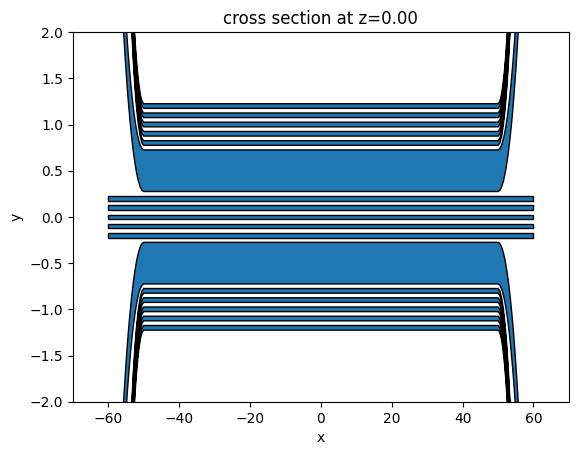

In [6]:
# define tidy3d geometries from the gds cell
eskid_geo = td.PolySlab.from_gds(
    cell_eskid,
    gds_layer=1,
    axis=2,
    slab_bounds=(-h / 2, h / 2),
)

# plot the geometries
fig, ax = plt.subplots()
for geo in eskid_geo:
    geo.plot(z=0, ax=ax)

ax.set_xlim(-0.7 * L, 0.7 * L)
ax.set_ylim(-0.2 * R, 0.2 * R)
ax.set_aspect("auto")
plt.show()

Define Tidy3D Structures using the previously defined geometries and materials.

In [7]:
# define tidy3d structures from the geometries
eskid_structure = [td.Structure(geometry=geo, medium=si) for geo in eskid_geo]

# define the substrate structure
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -h / 2)
    ),
    medium=sio2,
)

Define a ModeSource to excite the TE0 mode at the input waveguide and then define two ModeMonitors at the through port and cross port to measure the transmission. And finally we add a FieldMonitor at the $z=0$ plane to visualize the power propagation and coupling.

In [8]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)

input_x = -L / 2 - R
input_y = (N + 1) * p / 2 + w / 2 + R + lda0 / 4

mode_source = td.ModeSource(
    center=(input_x, input_y, 0),
    size=(5 * w, 0, 9 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission at the through port
mode_monitor_I1 = td.ModeMonitor(
    center=(-input_x, input_y, 0),
    size=(5 * w, 0, 9 * h),
    freqs=freqs,
    mode_spec=mode_spec,
    name="I1",
)

# add a mode monitor to measure transmission at the cross port
mode_monitor_I2 = td.ModeMonitor(
    center=(-input_x, -input_y, 0),
    size=(5 * w, 0, 9 * h),
    freqs=freqs,
    mode_spec=mode_spec,
    name="I2",
)

# add a filed monitor to visualize field distribution at z=0
field_monitor = td.FieldMonitor(
    size=(td.inf, td.inf, 0), freqs=[freq0], interval_space=(3, 3, 1), name="field"
)

Define a Tidy3D Simulation using the components above. Due to the thin anisotropic metamaterial claddings, a fine grid needs to be used to ensure an accurate simulation. Here we use the automatic nonuniform grid with `min_steps_per_wvl` set to 20. 

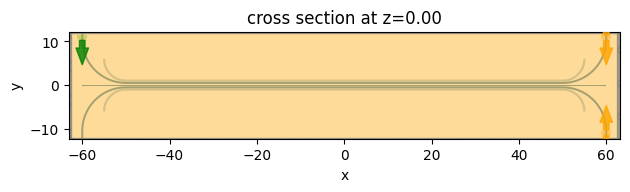

In [9]:
# simulation domain size
Lx = 1.25 * L
Ly = 2.4 * R
Lz = 9 * h
sim_size = (Lx, Ly, Lz)

run_time = 5e-12  # simulation run time

# construct simulation
sim_eskid = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=eskid_structure + [substrate],
    sources=[mode_source],
    monitors=[mode_monitor_I1, mode_monitor_I2, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

# plot the simulation
sim_eskid.plot(z=0)
plt.show()

Since the simulation contains very thin waveguides, it's crucial to have a sufficiently small grid size to resolve them. We can inspect the grid by using the `plot_grid` method.

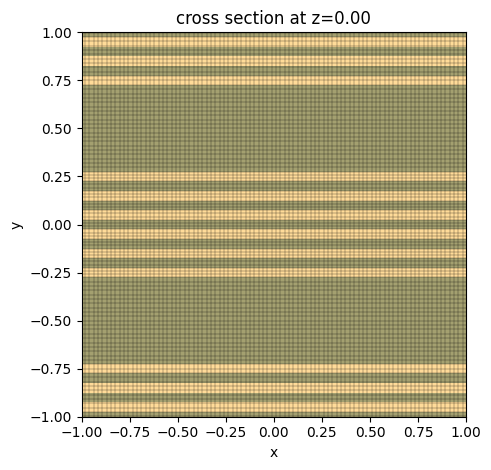

In [11]:
# inspect the grid
ax = sim_eskid.plot(z=0, hlim=[-1,1], vlim=[-1,1])
sim_eskid.plot_grid(z=0, ax=ax, hlim=[-1,1], vlim=[-1,1])
plt.show()

Once everything is confirmed, we submit the simulation job to the server. The fine grid combined with the large simulation domain will lead to a higher FlexCredit cost. Before running the simulation, we can get a cost estimation using `estimate_cost`. This prevents us from accidentally running large jobs that we set up by mistake. The estimated cost is the maximum cost corresponding to running all the time steps.

In [11]:
job = web.Job(simulation=sim_eskid, task_name="eskid", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)

print(f"The estimated maximum cost is {estimated_cost:.3f} Flex Credits.")

[14:25:48] Created task 'eskid' with task_id 'fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1'.           ]8;id=683644;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=495520;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=155732;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=278296;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=773906;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=679446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1\taskId]8;;\]8;id=773906;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1\=]8;;\]8;id=761215;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1\fdve]8;;\]8;id=773906;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1\-8bfa1da0-0bf3-4592-bfb4-a98b14277dc]8;;\              
           ]8;id=773906;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bfa1da0-0bf3-4592-bfb4-a98b14277dc0v1\0v1']8;;\.                                                                                                   

Output()

The estimated maximum cost is 14.289 Flex Credits.


The cost is reasonable given the simulation size so we can run the simulation now.

In [12]:
sim_data_eskid = job.run(path="data/eskid.hdf5")

[14:25:51] status = queued                                                                            ]8;id=865561;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=490148;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[14:25:57] status = preprocess                                                                        ]8;id=155165;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=116059;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[14:26:04] Maximum FlexCredit cost: 14.289. Use 'web.real_cost(task_id)' to get the billed FlexCredit ]8;id=472078;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=414525;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=776657;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=785408;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=411716;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=44649;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[14:39:38] early shutoff detected, exiting.                                                           ]8;id=97195;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=547893;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=27857;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=202338;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[14:39:45] status = success                                                                           ]8;id=212419;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=259342;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[14:39:49] loading SimulationData from data/eskid.hdf5                                                ]8;id=403608;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=688978;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

## Result Analysis and Visualization 

We define a helper function `postprocess` to plot the crosstalk and field distribution. The crosstalk is defined as $I_2/I_1$, where $I_1$ is the power transmitted to the through port and $I_2$ is the power transmitted to the cross port.

In [13]:
def postprocess(sim_data):
    I1 = np.abs(sim_data["I1"].amps.sel(mode_index=0, direction="+")) ** 2
    I2 = np.abs(sim_data["I2"].amps.sel(mode_index=0, direction="-")) ** 2
    crosstalk = I2 / I1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

    ax1.plot(ldas, 10 * np.log10(crosstalk))
    ax1.set_xlabel("Wavelength ($\mu m$)")
    ax1.set_xlim(np.min(ldas), np.max(ldas))
    ax1.set_ylim(-80, 0)
    ax1.set_ylabel("Crosstalk (dB)")

    sim_data.plot_field("field", "E", "abs", vmin=0, vmax=80, ax=ax2)
    ax2.set_aspect("auto")
    plt.show()

Call the `postprocess` function on the simulation data of the eskid waveguide simulation. Here we see the crosstalk is below -40 dB around the 100 nm bandwidth. At about 1550 nm, exception coupling occurs and the crosstalk is well below -80 dB. The exceptional coupling wavelength can be effectively tuned by changing the geometric parameters such as the waveguide width.

From the field distribution plot, we see the field stays at the top waveguide throughout the coupling regime, confirming the low crosstalk.

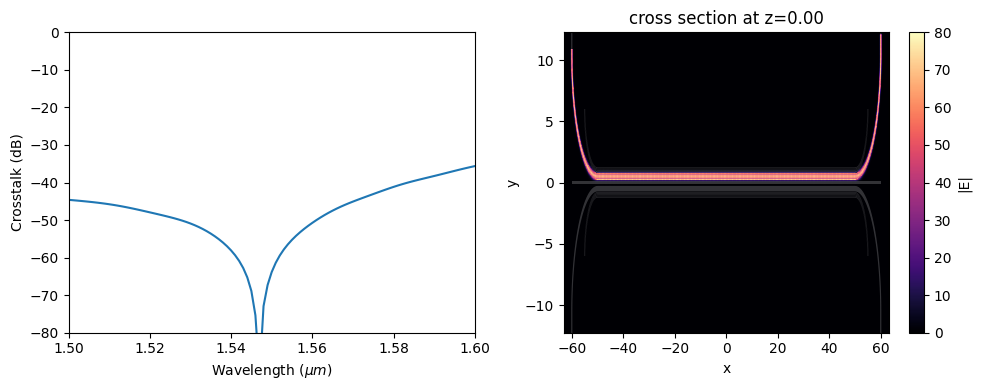

In [14]:
postprocess(sim_data_eskid)

## Reference Simulation

The crosstalk of the eskid waveguide has been shown to be very low. As a comparison, we simulate two strip waveguides with the same spacing without the anisotropic metamaterial claddings. 

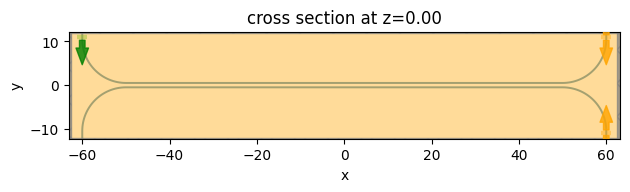

In [15]:
# define geometries for the bare strip waveguides
ref_geo = td.PolySlab.from_gds(
    cell_ref,
    gds_layer=1,
    axis=2,
    slab_bounds=(-h / 2, h / 2),
)

# define structures for the bare strip waveguides
ref_structure = [td.Structure(geometry=geo, medium=si) for geo in ref_geo]

# copy the simulation and update the structures to bare strip waveguides
sim_ref = sim_eskid.copy(update={"structures": ref_structure + [substrate]})

# plot simulation
sim_ref.plot(z=0)
plt.show()

submit the simulation job to the server.

In [16]:
sim_data_ref = web.run(sim_ref, task_name="ref", path="data/ref.hdf5")

[14:39:54] Created task 'ref' with task_id 'fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1'.             ]8;id=489715;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=244585;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=876228;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=369611;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=421734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=862277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1\taskId]8;;\]8;id=421734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1\=]8;;\]8;id=533216;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1\fdve]8;;\]8;id=421734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1\-a4444ef4-152b-4d19-9c15-92169d2f877]8;;\              
           ]8;id=421734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4444ef4-152b-4d19-9c15-92169d2f8777v1\7v1']8;;\.                                                                                                   

Output()

[14:39:56] status = queued                                                                            ]8;id=266863;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=981058;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[14:40:04] status = preprocess                                                                        ]8;id=827037;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=897249;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[14:40:11] Maximum FlexCredit cost: 12.242. Use 'web.real_cost(task_id)' to get the billed FlexCredit ]8;id=990019;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=269467;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=27266;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=294140;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=303963;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=369463;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[14:51:45] early shutoff detected, exiting.                                                           ]8;id=245572;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=90561;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

[14:51:46] status = postprocess                                                                       ]8;id=727825;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=262024;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[14:51:54] status = success                                                                           ]8;id=65193;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=956018;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[14:51:57] loading SimulationData from data/ref.hdf5                                                  ]8;id=270049;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=495997;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Apply the same visualization to the simulation data. We can see that the crosstalk is much larger in the bare strip waveguide case, around -10 dB. In the field distribution plot, a noticeable amount of energy is coupled to the lower waveguide. This comparison further validifies the effectiveness of the anisotropic metamaterial cladding design for crosstalk suppression.

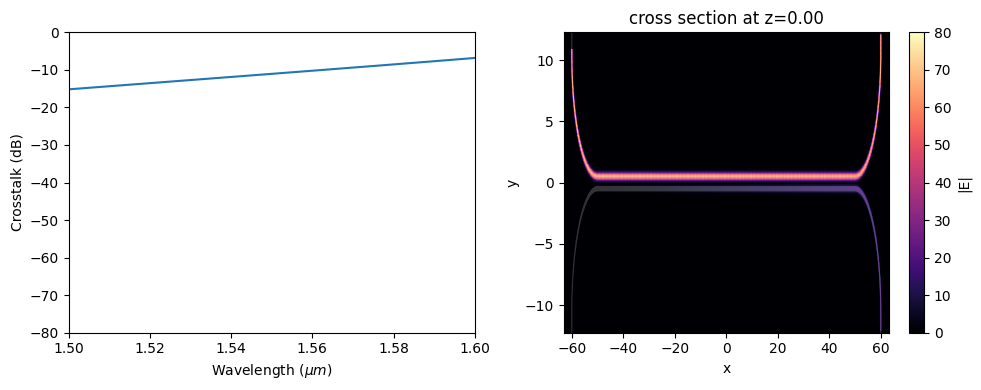

In [17]:
postprocess(sim_data_ref)

## Final Remark 

The proposed design in this example achieves exceptional coupling only for the TE mode. A different anisotropic metamaterial-based design achieving zero crosstalk for the TM mode is proposed by the same research group. For detail, please refer to `Kabir, M.F., Mia, M.B., Ahmed, I. et al. Anisotropic leaky-like perturbation with subwavelength gratings enables zero crosstalk. Light Sci Appl 12, 135 (2023)` [DOI:10.1038/s41377-023-01184-5](https://doi.org/10.1038/s41377-023-01184-5).